In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback

import sentencepiece as spm #https://github.com/google/sentencepiece

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [4]:
PATH = Path('./data/rnn/')

**See RNN notebook for DataBunch generation.  It is the same for all LMs, so just loaded here**

### Sentence Piece Tokenizer

In [5]:
## New Line char for replacement in text
NL = 'xxnl'
defaults.text_spec_tok.append(NL) #add a New Line special char

In [6]:
def sub_nl(t:str) -> str:
    "Replaces \n by xxnl"
    return t.replace("\r\n","\n").replace("\n",NL+" ")

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#?!@,])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, 
                 rm_useless_spaces, sub_nl]

In [7]:
model_prefix = 'all_tweets_es_0509'

In [8]:
## itos from m.vocab file: just read directly and populate the dictionary
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [9]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix,pre_rules=default_rules)
sp_vocab = Vocab(itos)

In [10]:
data = load_data(PATH,'tweet_es_lm_data_SP_more_rules.pkl')

## Bulid and train model

In [11]:
config = tfmer_lm_config.copy()
config['n_layers'] = 8
config['ctx_len'] = 128
config['d_model'] = 512
config['d_inner'] = 2048
config['mask'] = True  
config['out_bias'] = True

config

{'ctx_len': 128,
 'n_layers': 8,
 'n_heads': 12,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.0,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': False,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mask': True}

In [12]:
model = get_language_model(Transformer, len(data.vocab.itos), config=config, drop_mult=1.0)

In [13]:
model[0].encoder.weight.std()

tensor(0.9999, grad_fn=<StdBackward0>)

In [14]:
class tfm_decoder(nn.Module):
    def __init__(self,d_model=768,d_vocab=8842, enc:nn.Module=None):
        super().__init__()
        self.tgt_word_prj = nn.Linear(d_model, d_vocab, bias=False)
        nn.init.xavier_normal_(self.tgt_word_prj.weight)
        if enc: self.tgt_word_prj.weight = enc.weight
        self.x_logit_scale = (d_model ** -0.5)
        
    def forward(self,input:Tuple[Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs = input
        decoded = self.tgt_word_prj(raw_outputs[0]) * self.x_logit_scale
        return decoded, raw_outputs, outputs

model[1] = tfm_decoder(512, len(data.vocab.itos), model[0].encoder)

In [15]:
from fastai.basic_train import LearnerCallback

class my_custom_optimizer(LearnerCallback):
    def __init__(self, learn:Learner, d_model, n_warmup_steps):
        super().__init__(learn)
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5) ## from Attention paper description
        
    def on_train_being(self,**kwargs):
        self.opt = self.learn.opt

    def on_backward_end(self, **kwargs):
        'Before .step() and .zero()'
        self.n_current_steps += 1
        lr_scale =  np.min([
                        np.power(self.n_current_steps, -0.5),
                        np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])
        self.opt.lr = self.init_lr * lr_scale


In [16]:
learn = LanguageLearner(data, model, **{'alpha':0,'beta':0})
learn.callbacks.append(my_custom_optimizer(learn,512,4000))
learn.unfreeze()
learn.model

SequentialRNN(
  (0): Transformer(
    (encoder): Embedding(60000, 512)
    (pos_enc): Embedding(128, 512)
    (drop_emb): Dropout(p=0.1)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadAttention(
          (attention): Linear(in_features=512, out_features=2304, bias=True)
          (out): Linear(in_features=768, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1)
          (drop_res): Dropout(p=0.1)
          (ln): LayerNorm(torch.Size([512]), eps=1e-05, elementwise_affine=True)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GeLU()
            (2): Linear(in_features=2048, out_features=512, bias=True)
            (3): Dropout(p=0.1)
            (4): MergeLayer()
            (5): LayerNorm(torch.Size([512]), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (1): DecoderLayer(
        (mhra): MultiHeadAttention(
  

In [20]:
learn.fit(25,callbacks=[SaveModelCallback(learn,every='improvement',mode='max',
                                          monitor='accuracy',name='tfm_lm_acc')])

epoch,train_loss,valid_loss,accuracy,time
0,5.160767,5.107263,0.272835,29:45
1,4.877648,4.814402,0.290447,29:51
2,4.732834,4.677676,0.299580,29:52
3,4.619518,4.588174,0.306295,29:53
4,4.568750,4.523123,0.311535,29:53
5,4.511124,4.470747,0.315666,29:53
6,4.452850,4.427056,0.319074,29:52
7,4.406425,4.393414,0.322658,29:53
8,4.353670,4.360425,0.325602,29:53
9,4.327995,4.333560,0.328147,29:53


Better model found at epoch 0 with accuracy value: 0.2728349268436432.
Better model found at epoch 1 with accuracy value: 0.2904468774795532.
Better model found at epoch 2 with accuracy value: 0.29958027601242065.
Better model found at epoch 3 with accuracy value: 0.3062945008277893.
Better model found at epoch 4 with accuracy value: 0.31153467297554016.
Better model found at epoch 5 with accuracy value: 0.315665602684021.
Better model found at epoch 6 with accuracy value: 0.3190743327140808.
Better model found at epoch 7 with accuracy value: 0.3226577341556549.
Better model found at epoch 8 with accuracy value: 0.32560229301452637.
Better model found at epoch 9 with accuracy value: 0.32814735174179077.
Better model found at epoch 10 with accuracy value: 0.33088964223861694.
Better model found at epoch 11 with accuracy value: 0.33303043246269226.
Better model found at epoch 12 with accuracy value: 0.33480456471443176.
Better model found at epoch 13 with accuracy value: 0.33701485395431

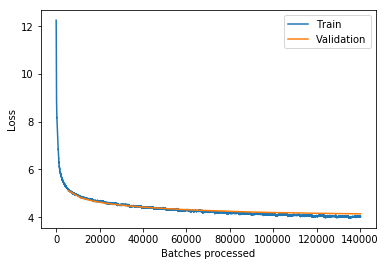

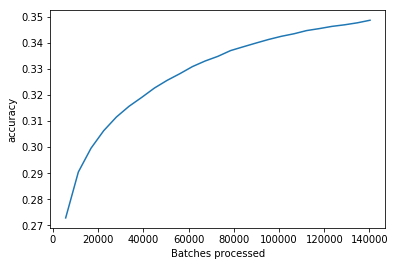

In [21]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [22]:
learn.save_encoder('twitter_es_enc_Tfm_0516')

In [23]:
learn.save("twitter_raw_es_more_rules_Tfm_20190516")